<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Exploratory Data Analysis (EDA)</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. Datasets](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
* [2. Preprocessing & Feature Engineering](#2)
  * [2.1 Target variable distribution](#2.1)
  * [2.2 Missing values](#2.2)
  * [2.3 Exploratory Analysis](#2.3)
  * [2.4 Features Importance](#2.4)

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [128]:
hourly_data = pd.read_csv('../data/interim/hourly_data.csv')
all_data = pd.read_csv('../data/interim/all_data.csv')
rentals = pd.read_csv('../data/interim/new_features_rentals.csv')
hourly_data.head()

,rental_date,rental_hour,rental_day,rental_year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rain,temp,rhum,wdsp,count
0,2021-02-01,6,1,2021,False,0,Monday,True,Winter,True,Night,0.0,3.4,98,3,1
1,2021-02-01,8,1,2021,False,0,Monday,True,Winter,True,Morning,0.0,3.5,93,4,2
2,2021-02-01,9,1,2021,False,0,Monday,True,Winter,True,Morning,0.0,2.6,93,2,4
3,2021-02-01,10,1,2021,False,0,Monday,True,Winter,True,Morning,0.0,4.1,97,4,3
4,2021-02-01,11,1,2021,False,0,Monday,True,Winter,False,Morning,0.0,5.2,86,6,12


In [129]:
all_data.head()

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_hour,rental_day,rental_month,rental_year,...,dayofweek,working_day,season,peak,timesofday,date,rain,temp,rhum,wdsp
0,2021-02-01 06:58:08,41,"[[53.3292, -6.23173], [53.3292, -6.23177], [53...",37.0,2021-02-01 14:45:59,2021-02-01 00:00:00,6,1,2,2021,...,Monday,True,Winter,True,Night,2021-02-01 06:00:00,0.0,3.4,98,3
1,2021-02-01 08:00:38,83,"[[53.3425, -6.29327], [53.3425, -6.29327], [53...",68.0,2021-02-01 16:15:25,2021-02-01 00:00:00,8,1,2,2021,...,Monday,True,Winter,True,Morning,2021-02-01 08:00:00,0.0,3.5,93,4
2,2021-02-01 08:51:20,100,"[[53.3558, -6.25753], [53.3558, -6.25753], [53...",85.0,2021-02-04 11:23:41,2021-02-01 00:00:00,8,1,2,2021,...,Monday,True,Winter,True,Morning,2021-02-01 08:00:00,0.0,3.5,93,4
3,2021-02-01 09:01:31,34,"[[53.3561, -6.25709], [53.356, -6.25704], [53....",75.0,2021-02-01 15:21:40,2021-02-01 00:00:00,9,1,2,2021,...,Monday,True,Winter,True,Morning,2021-02-01 09:00:00,0.0,2.6,93,2
4,2021-02-01 09:39:30,7,"[[53.3557, -6.2576], [53.3557, -6.2576], [53.3...",18.0,2021-02-01 11:13:39,2021-02-01 00:00:00,9,1,2,2021,...,Monday,True,Winter,True,Morning,2021-02-01 09:00:00,0.0,2.6,93,2


In [130]:
rentals.head()

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_hour,rental_day,rental_month,rental_year,duration,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday
0,2021-02-01 06:58:08,41,"[[53.3292, -6.23173], [53.3292, -6.23177], [53...",37.0,2021-02-01 14:45:59,2021-02-01 00:00:00,6,1,2,2021,467.850000,False,0,Monday,True,Winter,True,Night
1,2021-02-01 08:00:38,83,"[[53.3425, -6.29327], [53.3425, -6.29327], [53...",68.0,2021-02-01 16:15:25,2021-02-01 00:00:00,8,1,2,2021,494.783333,False,0,Monday,True,Winter,True,Morning
2,2021-02-01 08:51:20,100,"[[53.3558, -6.25753], [53.3558, -6.25753], [53...",85.0,2021-02-04 11:23:41,2021-02-01 00:00:00,8,1,2,2021,4472.350000,False,0,Monday,True,Winter,True,Morning
3,2021-02-01 09:01:31,34,"[[53.3561, -6.25709], [53.356, -6.25704], [53....",75.0,2021-02-01 15:21:40,2021-02-01 00:00:00,9,1,2,2021,380.150000,False,0,Monday,True,Winter,True,Morning
4,2021-02-01 09:39:30,7,"[[53.3557, -6.2576], [53.3557, -6.2576], [53.3...",18.0,2021-02-01 11:13:39,2021-02-01 00:00:00,9,1,2,2021,94.150000,False,0,Monday,True,Winter,True,Morning


In [131]:
hourly_data[['temp','rain','wdsp','rhum','count']].describe()

,temp,rain,wdsp,rhum,count
count,7447.000000,7447.000000,7447.000000,7447.000000,7447.000000
mean,10.473412,0.059098,9.001611,80.386464,4.780851
std,5.018159,0.321823,4.513983,11.907366,3.475063
min,-4.000000,0.000000,1.000000,24.000000,1.000000
25%,6.800000,0.000000,6.000000,73.000000,2.000000
50%,10.200000,0.000000,8.000000,82.000000,4.000000
75%,14.200000,0.000000,11.000000,89.000000,7.000000
max,26.300000,10.300000,35.000000,100.000000,26.000000


In [132]:
hourly_data = hourly_data.astype({'holiday': 'category', 
                                  'dayofweek': 'category', 
                                  'working_day': 'category',
                                  'season': 'category', 
                                  'peak': 'category', 
                                  'timesofday': 'category'
                                  })

In [133]:
hourly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7447 entries, 0 to 7446
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   rental_date  7447 non-null   object  
 1   rental_hour  7447 non-null   int64   
 2   rental_day   7447 non-null   int64   
 3   rental_year  7447 non-null   int64   
 4   holiday      7447 non-null   category
 5   dayofweek_n  7447 non-null   int64   
 6   dayofweek    7447 non-null   category
 7   working_day  7447 non-null   category
 8   season       7447 non-null   category
 9   peak         7447 non-null   category
 10  timesofday   7447 non-null   category
 11  rain         7447 non-null   float64 
 12  temp         7447 non-null   float64 
 13  rhum         7447 non-null   int64   
 14  wdsp         7447 non-null   int64   
 15  count        7447 non-null   int64   
dtypes: category(6), float64(2), int64(7), object(1)
memory usage: 626.7+ KB


In [134]:
hourly_data[['holiday','dayofweek','working_day','season','peak','timesofday']].describe()

,holiday,dayofweek,working_day,season,peak,timesofday
count,7447,7447,7447,7447,7447,7447
unique,2,7,2,4,2,4
top,False,Saturday,True,Winter,False,Afternoon
freq,7165,1105,5062,2155,4925,2299


### Rentals by Season

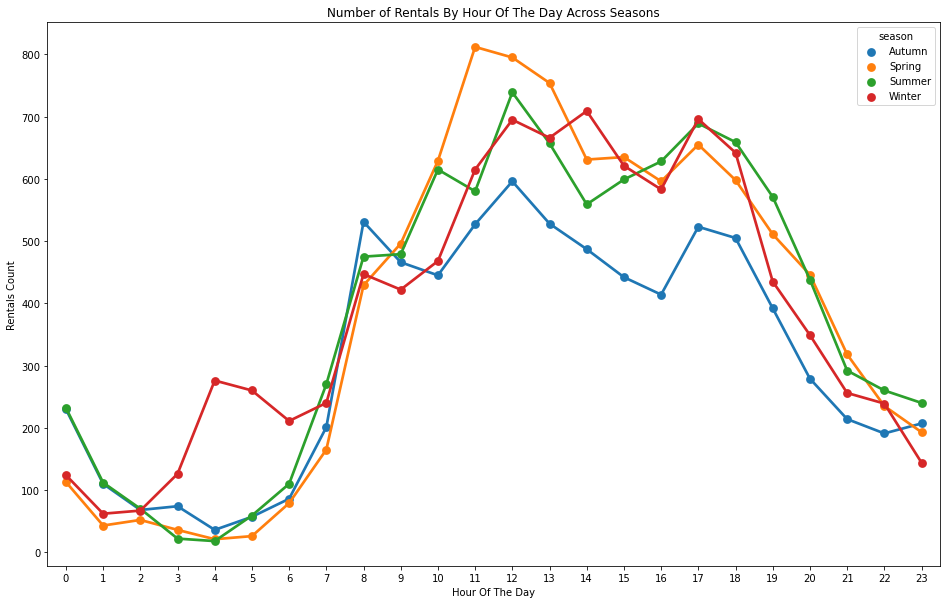

In [181]:
# 0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
# season_map = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
season_freq = hourly_data.groupby(['season', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
# season_freq['season'] = season_freq['season'].map(lambda d : season_map[d])
fig, ax = plt.subplots(figsize=(16, 10))
sns.pointplot(x=season_freq["rental_hour"], y=season_freq["count"], hue=season_freq["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Seasons")
plt.show()

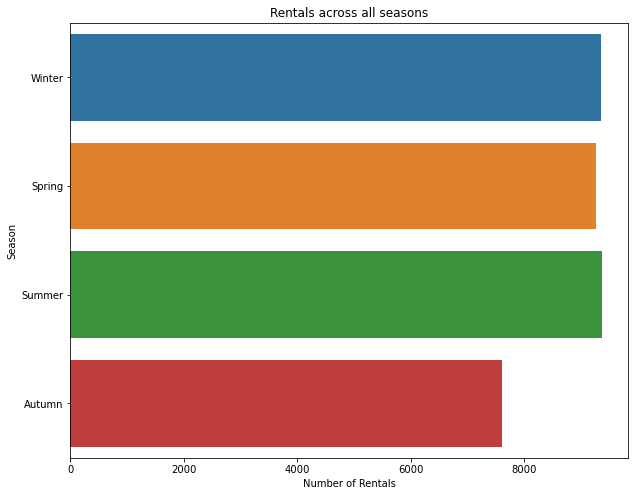

In [177]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=season_freq.groupby('season')['count'].sum().reset_index(), x='count', y='season', order=['Winter','Spring','Summer','Autumn'], ci=None)
ax.set(xlabel='Number of Rentals', ylabel='Season', title='Rentals across all seasons')
plt.show()

### Rentals by Days of the Week

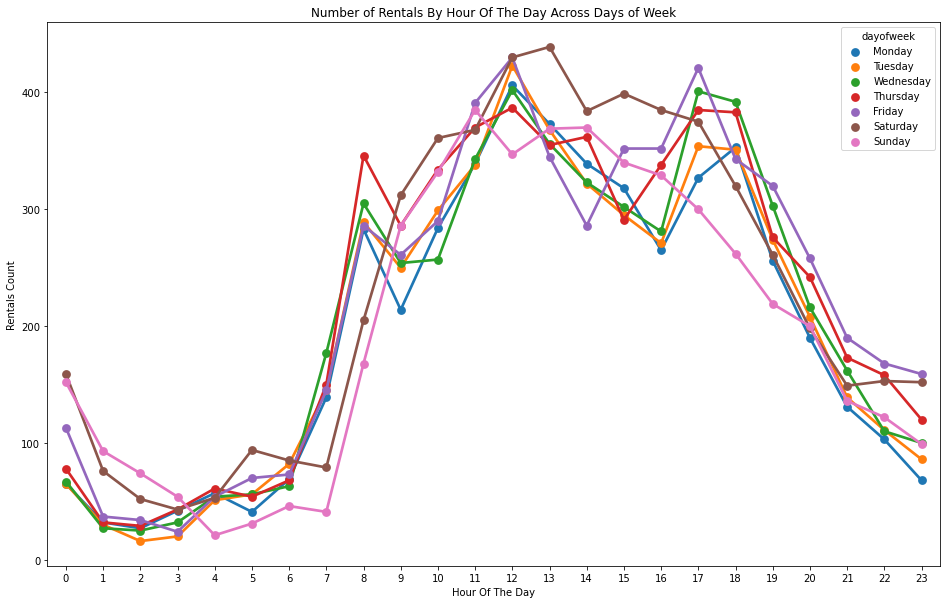

In [182]:
# day_of_week_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
day_of_week = hourly_data.groupby(['dayofweek', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
# day_of_week['dayofweek'] = day_of_week['dayofweek'].map(lambda d : day_of_week_map[d])
fig, ax = plt.subplots(figsize=(16, 10))
sns.pointplot(x=day_of_week["rental_hour"], 
              y=day_of_week["count"], 
              hue=day_of_week["dayofweek"], 
              ax=ax,
              hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Days of Week")
plt.show()

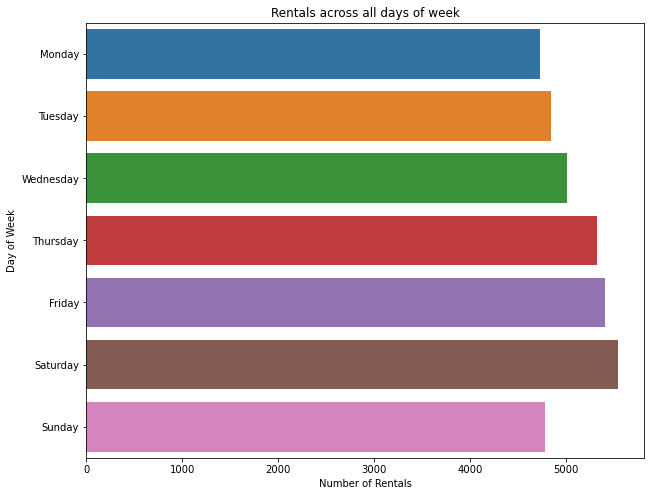

In [179]:
day_of_week = hourly_data.groupby('dayofweek')['count'].agg('sum').reset_index(name='count')
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=day_of_week, x='count', y='dayofweek', ci=None, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set(xlabel='Number of Rentals', ylabel='Day of Week', title='Rentals across all days of week')
plt.show()

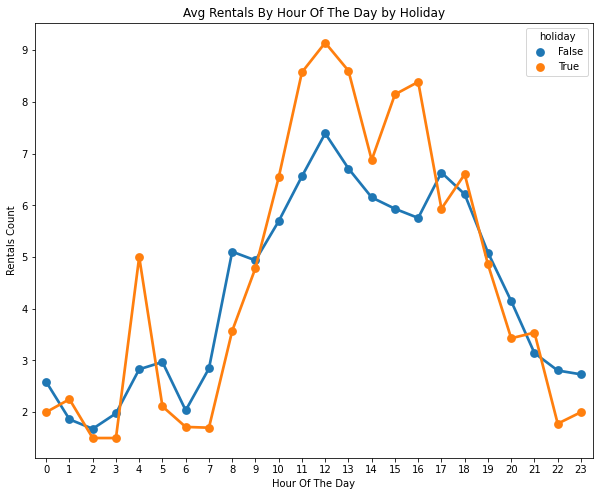

In [180]:
hourly_count = hourly_data.groupby(['rental_hour','holiday'])['count'].agg('mean').reset_index(name='count')

fig, ax = plt.subplots(figsize=(10, 8))
sns.pointplot(x=hourly_count['rental_hour'], y=hourly_count['count'], hue=hourly_count['holiday'], ax=ax)
ax.set(xlabel='Hour Of The Day', 
       ylabel='Rentals Count', 
       title="Avg Rentals By Hour Of The Day by Holiday")
plt.show()

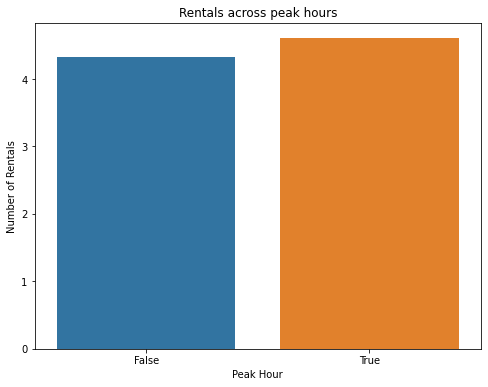

In [183]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=hourly_count, x='holiday', y='count', ci=None)
ax.set(xlabel='Peak Hour', ylabel='Number of Rentals', title='Rentals across peak hours')
plt.show()

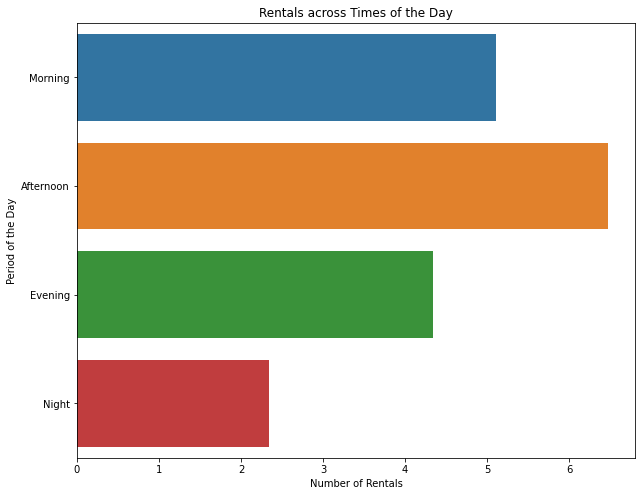

In [184]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=hourly_data, x='count', y='timesofday', ci=None, order=['Morning','Afternoon','Evening','Night'])
ax.set(xlabel='Number of Rentals', ylabel='Period of the Day', title='Rentals across Times of the Day')
plt.show()

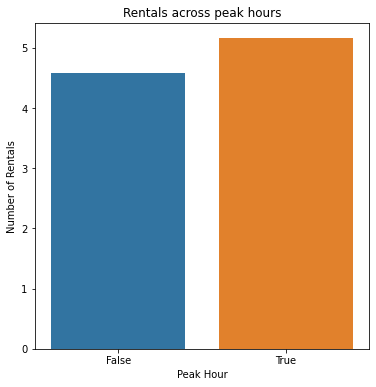

In [175]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(data=hourly_data, x='peak', y='count', ci=None)
ax.set(xlabel='Peak Hour', ylabel='Number of Rentals', title='Rentals across peak hours')
plt.show()

In [143]:
from scipy import stats
a = hourly_data['peak']
b = hourly_data['count']

stats.pointbiserialr(a,b)

PointbiserialrResult(correlation=0.07836518001261787, pvalue=1.2711776559194791e-11)

## Battery distribution

In [144]:
battery_dist = all_data.copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    battery_dist['battery_status'] = pd.cut(battery_dist['start_battery'], bins=bins, labels=labels, right=False)

    s = battery_dist.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    return pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}, labels)

In [145]:
group_battery_status(battery_dist)

,counts,per,per100
< 30%,3040,0.086731,8.7%
30% - 50%,6186,0.176486,17.6%
50% - 80%,15077,0.430145,43.0%
> 80%,10748,0.306639,30.7%


<AxesSubplot:xlabel='start_battery', ylabel='Count'>

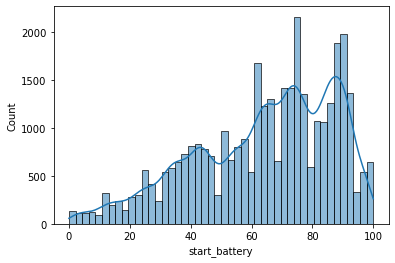

In [146]:
sns.histplot(data=rentals, x='start_battery', kde=True)

In [147]:
print('Mean of rentals duration: {} minutes'.format(round(all_data['duration'].mean(),2)))

Mean of rentals duration: 974.27 minutes


## BoxPlot analysis

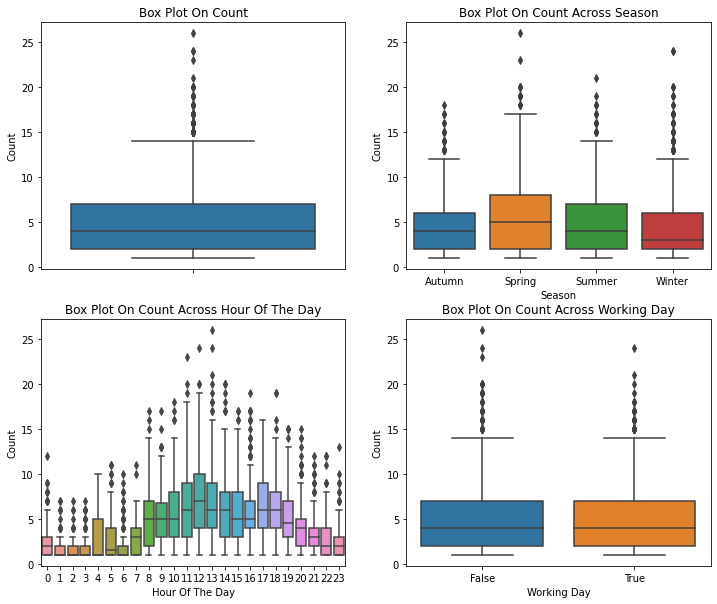

In [148]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=hourly_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=hourly_data,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hourly_data,y="count",x="rental_hour",orient="v",ax=axes[1][0])
sns.boxplot(data=hourly_data,y="count",x="working_day",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Seasons")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hours Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count by Working Day")

plt.show()

## Correlation Matrix

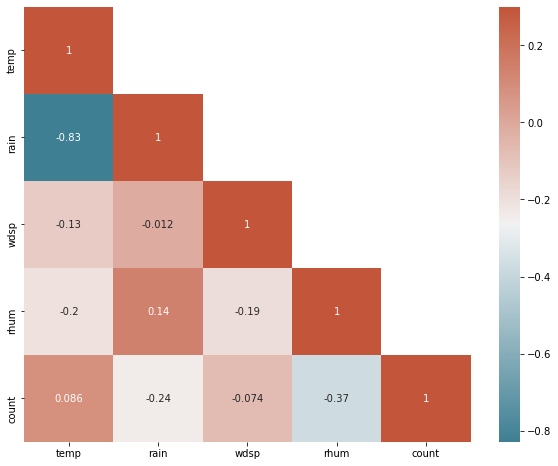

In [185]:
corrMatt = hourly_data[['temp','rain','wdsp','rhum','count']].corr(method='kendall')
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()

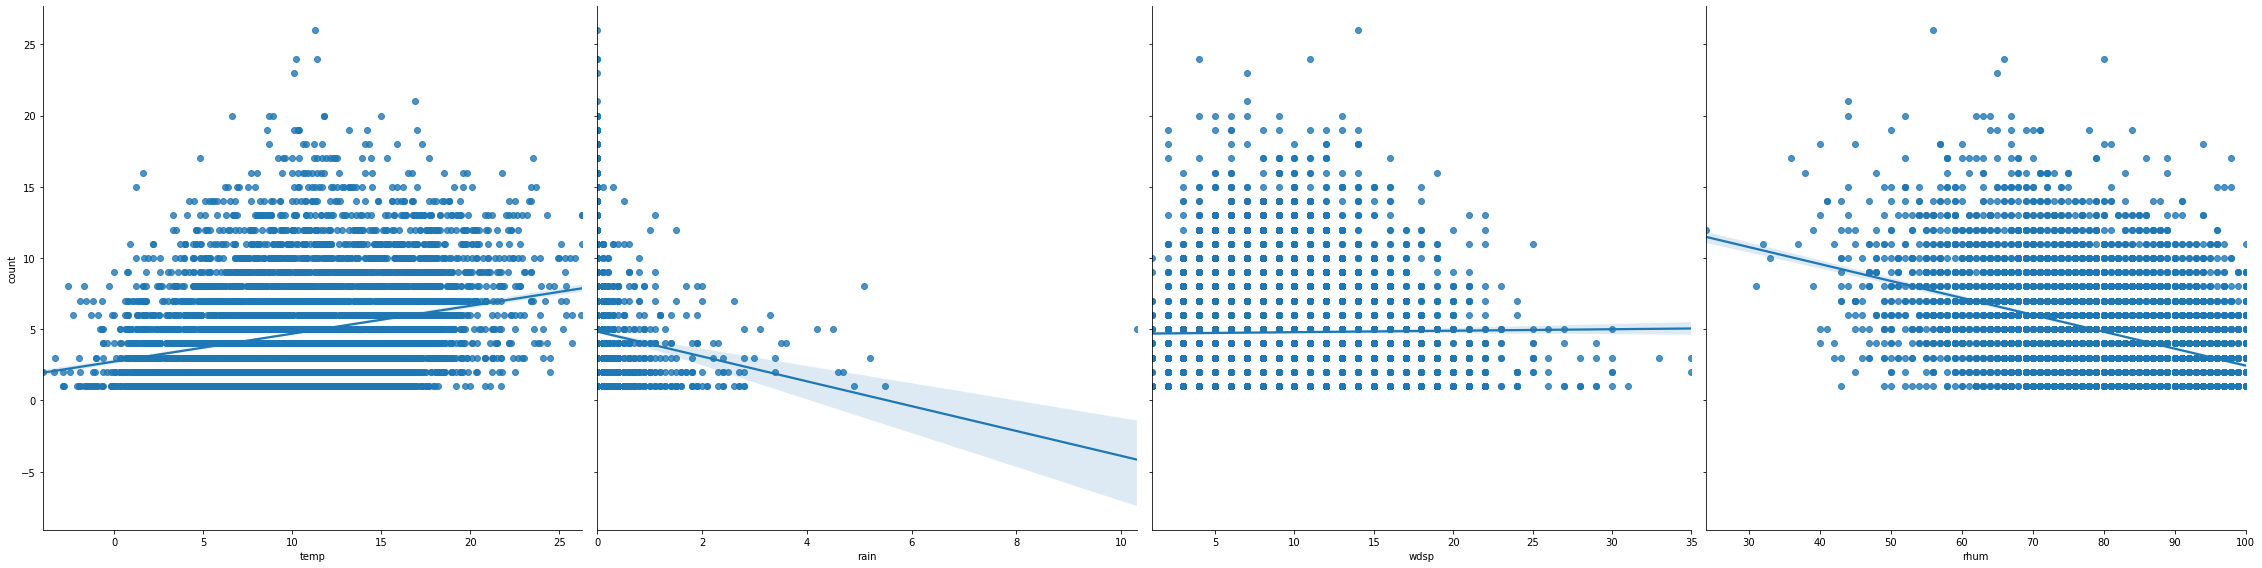

In [189]:
sns.pairplot(hourly_data, 
             x_vars=['temp','rain','wdsp','rhum'],
             dropna=True, 
             y_vars='count', 
             height=8, 
             kind="reg", 
             palette='Set1')
plt.show()

## Outlier Analysis

In [151]:
hourly_data['count'].describe()

count    7447.000000
mean        4.780851
std         3.475063
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        26.000000
Name: count, dtype: float64

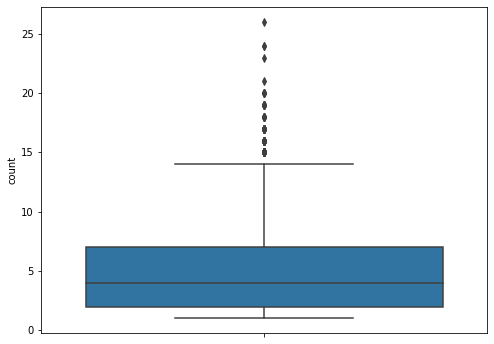

In [186]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=hourly_data,y="count",orient="v",ax=ax)
plt.show()

In [153]:
print('Outliers (#): {}'.format(round( hourly_data[hourly_data['count'] > 15].shape[0],2)))
print('Outliers (%): {}%'.format(round(( (hourly_data[hourly_data['count'] > 15].shape[0] / hourly_data.shape[0])*100 ),2)))

Outliers (#): 71
Outliers (%): 0.95%


In [170]:
hourlyDataOutliers = hourly_data[hourly_data['count'] > 15]
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(2*hourly_data["count"].std())] 

In [171]:
hourlyDataOutliers['dayofweek'].value_counts()

Saturday     22
Sunday       15
Friday       10
Tuesday       8
Wednesday     6
Monday        5
Thursday      5
Name: dayofweek, dtype: int64

In [168]:
hourlyDataOutliers['holiday'].value_counts(normalize=True)

False    0.84507
True     0.15493
Name: holiday, dtype: float64

In [169]:
hourlyDataOutliers['working_day'].value_counts(normalize=True)

False    0.605634
True     0.394366
Name: working_day, dtype: float64

In [158]:
hourlyDataOutliers['season'].value_counts()

Spring    27
Winter    26
Summer    13
Autumn     5
Name: season, dtype: int64

In [172]:
daily_count = hourly_data.groupby('rental_date')['count'].sum().reset_index()
daily_count_no_outliers = hourlyDataWithoutOutliers.groupby('rental_date')['count'].sum().reset_index()

In [160]:
daily_count.describe()

,count
count,392.000000
mean,90.823980
std,27.930351
min,14.000000
25%,73.000000
50%,90.000000
75%,111.000000
max,171.000000


In [187]:
print('Mean of daily rentals = {}'.format(round(daily_count['count'].mean(),2)))
print('Mean of daily rentals without Outliers = {}'.format(round(daily_count_no_outliers['count'].mean(),2)))

Mean of daily rentals = 90.82
Mean of daily rentals without Outliers = 77.33


In [162]:
hourlyDataOutliers = hourlyDataOutliers.join(daily_count.set_index('rental_date'), on='rental_date', lsuffix='_hour', rsuffix='_day')

In [163]:
hourlyDataOutliers[hourlyDataOutliers['count_day'] > 110].sort_values(by='count_day', ascending=False)

,rental_date,rental_hour,rental_day,rental_year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rain,temp,rhum,wdsp,count_hour,count_day
768,2021-03-17,12,17,2021,True,2,Wednesday,False,Winter,False,Afternoon,0.0,10.3,71,9,19,171
770,2021-03-17,14,17,2021,True,2,Wednesday,False,Winter,False,Afternoon,0.0,11.9,60,12,17,171
767,2021-03-17,11,17,2021,True,2,Wednesday,False,Winter,False,Morning,0.0,8.7,81,12,18,171
772,2021-03-17,16,17,2021,True,2,Wednesday,False,Winter,False,Afternoon,0.0,12.6,48,10,16,171
769,2021-03-17,13,17,2021,True,2,Wednesday,False,Winter,False,Afternoon,0.0,11.4,66,11,24,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,2021-06-22,12,22,2021,False,1,Tuesday,True,Summer,False,Afternoon,0.0,15.9,45,7,18,114
3196,2021-07-24,17,24,2021,False,5,Saturday,False,Summer,False,Afternoon,0.0,18.5,63,11,16,113
1011,2021-03-30,13,30,2021,False,1,Tuesday,True,Spring,False,Afternoon,0.0,13.9,62,8,17,113
1010,2021-03-30,12,30,2021,False,1,Tuesday,True,Spring,False,Afternoon,0.0,15.0,63,6,20,113


In [164]:
hourlyDataOutliers.to_csv('outliers.csv')

In [165]:
hourly_data[hourly_data['count'] > 20]

,rental_date,rental_hour,rental_day,rental_year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rain,temp,rhum,wdsp,count
769,2021-03-17,13,17,2021,True,2,Wednesday,False,Winter,False,Afternoon,0.0,11.4,66,11,24
806,2021-03-19,12,19,2021,False,4,Friday,True,Winter,False,Afternoon,0.0,10.2,80,4,24
1077,2021-04-03,11,3,2021,False,5,Saturday,False,Spring,False,Morning,0.0,10.1,65,7,23
1331,2021-04-17,13,17,2021,False,5,Saturday,False,Spring,False,Afternoon,0.0,11.3,56,14,26
2570,2021-06-22,13,22,2021,False,1,Tuesday,True,Summer,False,Afternoon,0.0,16.9,44,7,21


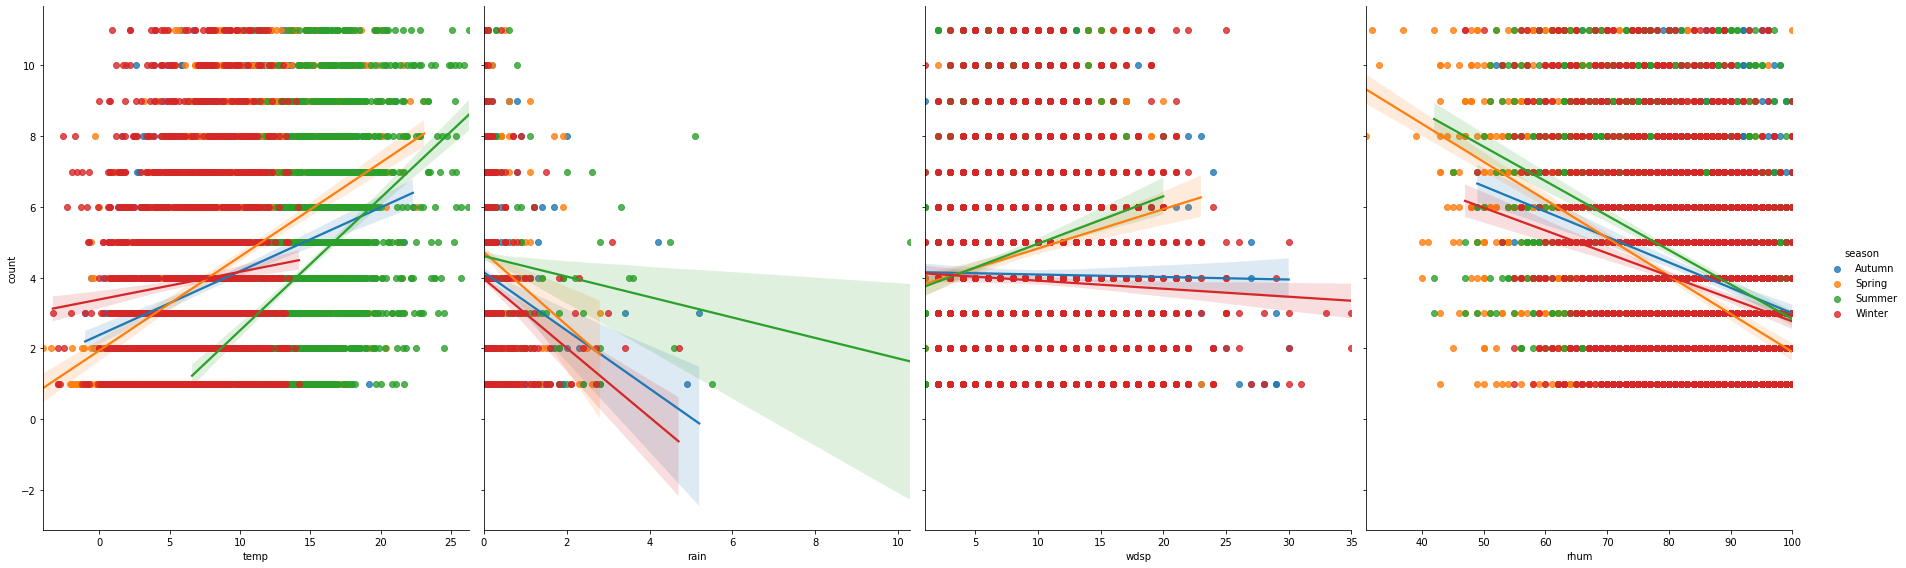

In [166]:
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(2*hourly_data["count"].std())] 
sns.pairplot(hourlyDataWithoutOutliers, 
             x_vars=['temp','rain','wdsp','rhum'],
             dropna=True, 
             y_vars='count', height=8, aspect=0.8, kind="reg", hue='season')
plt.show()

## Distribution of numerical features

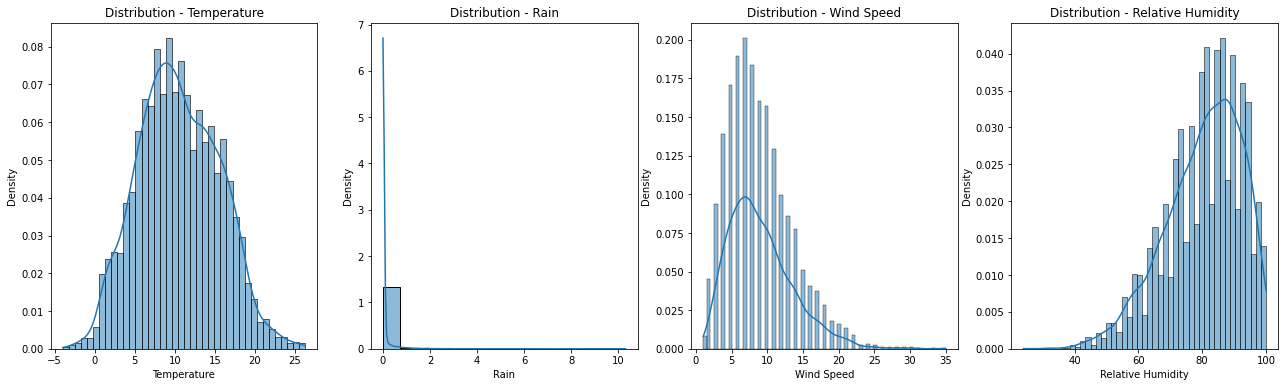

In [167]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(1, 4)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])

sns.histplot(hourly_data['temp'],ax=ax0, stat='density', kde=True)
sns.histplot(hourly_data['rain'],ax=ax1, stat='density', kde=True)
sns.histplot(hourly_data['wdsp'],ax=ax2, stat='density', kde=True)
sns.histplot(hourly_data['rhum'],ax=ax3, stat='density', kde=True)

ax0.set(xlabel='Temperature',title="Distribution - Temperature")
ax1.set(xlabel='Rain',title="Distribution - Rain")
ax2.set(xlabel='Wind Speed',title="Distribution - Wind Speed")
ax3.set(xlabel='Relative Humidity',title="Distribution - Relative Humidity")

plt.show()

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini